In [2]:
import numpy as np
import requests
import pandas as pd
import json
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
sns.set_style("whitegrid")
sns.set_context("poster")
#read in df
ppdf=pd.read_pickle('clean_data.pkl')

The goal of this data story is to find an interesting thing to analyze in future statistical analysis. The first major question we have to ask is what is normal variability in gambling lines? to do this we should exclude bad weather examples. This should show us what results are 'normal'

In [3]:
ppdf.over_diff=ppdf.total-ppdf.over_under_line

In [4]:
#make sure dtypes are right
ppdf=ppdf.astype({'precipitation':'float','schedule_week':'float'})
#this will be useful when we have df grouped
ppdf['true']=True
#lets take a quick look
ppdf.loc[:4455,'spread_favorite':]

,spread_favorite,results,results-spread,favorite_cover,over_under_line,total,over_diff,over_cover,weather_temperature,weather_wind_mph,stadium,coordinates,zipcode,weather_detail,precipitation,true
4450,-2.5,3.0,5.5,False,44.0,23.0,-21.0,False,68.0,11.0,Ralph Wilson Stadium,"(42.7738, -78.787)",14127,NaN,0.49,True
4451,-3.5,-27.0,-23.5,True,46.0,41.0,-5.0,False,66.0,16.0,Soldier Field,"(41.8623, -87.6167)",60605,NaN,0.00,True
4452,-5.5,-7.0,-1.5,True,47.0,35.0,-12.0,False,68.0,10.0,Cinergy Field,"(39.095, -84.516)",45202,NaN,2.48,True
4453,-4.0,7.0,11.0,False,46.0,35.0,-11.0,False,62.0,9.0,Mile High Stadium,"(39.7438, -105.02)",80204,NaN,0.00,True
4454,-4.0,-14.0,-10.0,True,43.0,48.0,5.0,True,72.0,0.0,Pontiac Silverdome,"(42.34, -83.0455)",48226,DOME,0.00,True
4455,-3.0,-27.0,-24.0,True,43.0,41.0,-2.0,False,62.0,15.0,Lambeau Field,"(44.5013, -88.0622)",54304,NaN,1.32,True


In [5]:

#Create two dataframes so we can attempt to control the effects of weather
bw=ppdf[(ppdf.weather_wind_mph>=14.9) | (ppdf.weather_temperature<=32)  | (ppdf.precipitation>=1.5)]
nw=ppdf[(ppdf.weather_wind_mph<14.9) & (ppdf.weather_temperature>32)& (ppdf.precipitation<1.5)]


In [6]:
#create a bad weather column. Coul be useful later on
ppdf['bw']=(ppdf.weather_wind_mph>=14.9) | (ppdf.weather_temperature<=32)  | (ppdf.precipitation>=1.5)



In [7]:
#Find covers by year and cover percentage for each year
grp=nw.groupby('schedule_season')
NW_covs_by_yr=grp.favorite_cover.sum()
percentage_NW_covs=NW_covs_by_yr/grp.true.sum()
NW_avg_result_sp=grp['results-spread'].mean()


In [8]:
#Find covers by year and cover percentage for each year
grp=nw.groupby('schedule_season')
NW_over_covs_by_yr=grp.over_cover.sum()
percentage_NW_over_covs=NW_over_covs_by_yr/grp.true.sum()
NW_avg_result_ov=grp['over_diff'].mean()

In [9]:
#Find covers by year and cover percentage for each year
grp=bw.groupby('schedule_season')
BW_covs_by_yr=grp.favorite_cover.sum()
percentage_BW_covs=BW_covs_by_yr/grp.true.sum()
BW_avg_result_sp=grp['results-spread'].mean()

In [10]:
#Find covers by year and cover percentage for each year
grp=bw.groupby('schedule_season')
BW_over_covs_by_yr=grp.over_cover.sum()
percentage_BW_over_covs=BW_over_covs_by_yr/grp.true.sum()
BW_avg_result_ov=grp['over_diff'].mean()

('Mean:', 0.12088986922050401, 'STD:', 1.00497353102711)


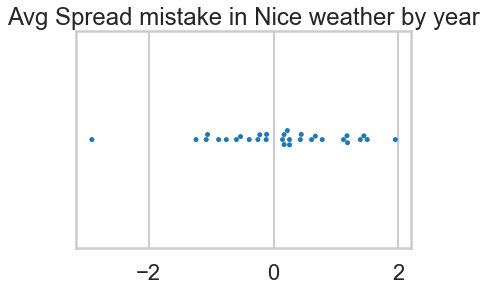

In [11]:
#Plot the average difference between spread and result in nice weather by year
_=sns.swarmplot( NW_avg_result_sp.values)
_=plt.title('Avg Spread mistake in Nice weather by year')
print('Mean:',NW_avg_result_sp.mean(), "STD:",NW_avg_result_sp.std())
plt.show()

('Mean:', 0.88727828566686, 'STD:', 0.8887786140798668)


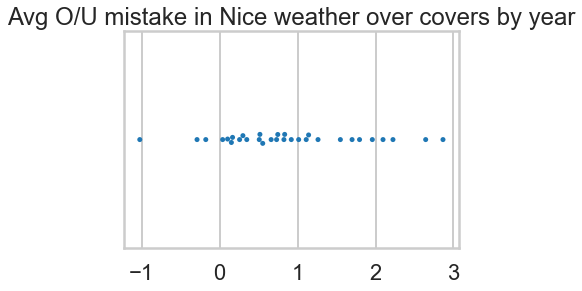

In [12]:
#Plot the average difference between the O/U and result in nice weather by year
_=sns.swarmplot( NW_avg_result_ov.values)
_=plt.title('Avg O/U mistake in Nice weather over covers by year')
print('Mean:',NW_avg_result_ov.mean(), "STD:",NW_avg_result_ov.std())
plt.show()

('Mean:', -0.4853833154202606, 'STD:', 2.9455962397640727)


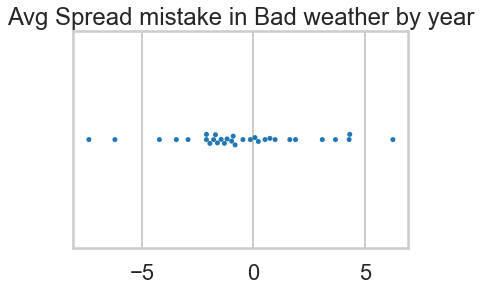

In [13]:
#Plot the average difference between spread and result in bad weather by year
_=sns.swarmplot( BW_avg_result_sp.values)
_=plt.title('Avg Spread mistake in Bad weather by year')
print('Mean:',BW_avg_result_sp.mean(), "STD:",BW_avg_result_sp.std())
plt.show()

('Mean:', -0.43446701006177346, 'STD:', 2.4953274073935496)


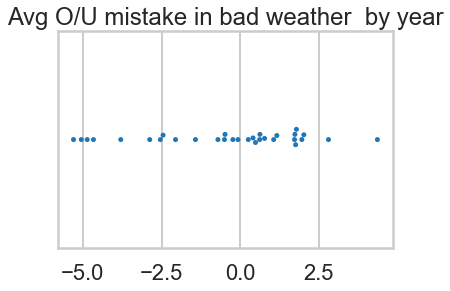

In [14]:
#Plot the average difference between O/U and result in bad weather by year
_=sns.swarmplot( BW_avg_result_ov.values)
_=plt.title('Avg O/U mistake in bad weather  by year')
print('Mean:',BW_avg_result_ov.mean(), "STD:",BW_avg_result_ov.std())
plt.show()

At first look it appears bad weather increases the variablitlity of the gambling lines as seen in there standard deviations. While this insight is interesting, it is questionable as to whether the effect is hampering the ability to produce accurate lines because the means do not appear to be far away from zero, whether or not bad weather is involved. Let's take the means and stds for different times in the season to see if some of the weather effect can be attributed to time of the year. 

In [15]:

nw_early=nw[nw['schedule_week']<=6]
nw_mid=nw[(nw['schedule_week']>6) &(nw['schedule_week']<13)]
nw_late=nw[(nw['schedule_week']>=14)]
print('Means:', nw_early['results-spread'].mean(), nw_mid['results-spread'].mean(), nw_late['results-spread'].mean())
print('std:', nw_early['results-spread'].std(), nw_mid['results-spread'].std(), nw_late['results-spread'].std())

('Means:', 0.3469601677148847, 0.06894956038870893, 0.13210130047912388)
('std:', 13.315301292708726, 13.136088376348987, 13.507937911054718)


In [16]:
bw_early=bw[bw['schedule_week']<=6]
bw_mid=bw[(bw['schedule_week']>6)&(bw['schedule_week']<=13)]
bw_late=bw[(bw['schedule_week']>13)]
print('Means:',bw_early['results-spread'].mean(), bw_mid['results-spread'].mean(), bw_late['results-spread'].mean())
print('std:', bw_early['results-spread'].std(), bw_mid['results-spread'].std(), bw_late['results-spread'].std())

('Means:', 1.05625, -1.1395939086294415, -0.46593406593406594)
('std:', 14.842356894243604, 12.098705831051689, 13.691955738095604)


In [17]:
nw_early=nw[nw['schedule_week']<=6]
nw_mid=nw[(nw['schedule_week']>6) &(nw['schedule_week']<13)]
nw_late=nw[(nw['schedule_week']>=14)]
print('Means:', nw['over_diff'].mean(), nw_mid['over_diff'].mean(), nw_late['over_diff'].mean())
print('std:', nw['over_diff'].std(), nw_mid['over_diff'].std(), nw_late['over_diff'].std())

('Means:', 0.8984134464341816, 1.0400277649236465, 1.2709787816563998)
('std:', 13.498509265549087, 13.509543739011535, 13.623263481154092)


In [18]:
bw_early=bw[bw['schedule_week']<=6]
bw_mid=bw[(bw['schedule_week']>6)&(bw['schedule_week']<=13)]
bw_late=bw[(bw['schedule_week']>13)]
print(bw_early['over_diff'].mean(), bw_mid['over_diff'].mean(), bw_late['over_diff'].mean())
print('std:', bw_early['over_diff'].std(), bw_mid['over_diff'].std(), bw_late['over_diff'].std())

(-1.65, -0.46446700507614214, 0.09230769230769231)
('std:', 13.418962458369107, 13.48889869995269, 14.336164113563294)


From this simple analysis, it looks like the Over/Under line is more influenced by weather than the spread, especially as the season goes on. Lets try and dive deeper into that by grouping the data by weeks of the season. Quick note, while their are only 17 weeks in the football season, I have coded playoff games to be numbers, so 18 is the wildcard round, 19 is the divisional, 20 is the confeence title game and 21 is the superbowl. I do not think that this data has to be seperated from the rest because I believe the relationship between the gambling lines and the weather are no different then in the regular season.

Text(0,0.5,'Spread diff')

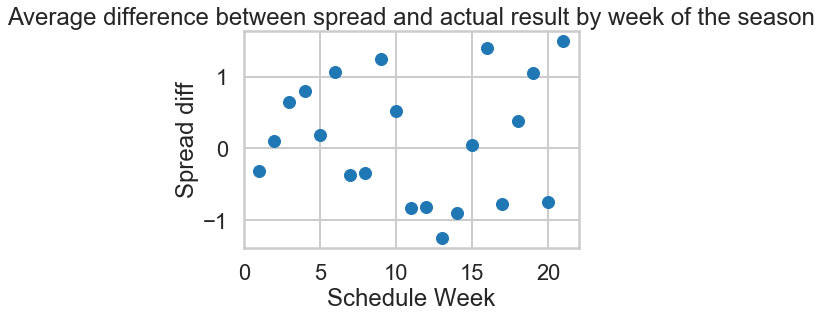

In [39]:
ppdf['over_diffabs']=ppdf.over_diff.abs()
ppdf['resultmSpreadabs']=ppdf['results-spread'].abs()
grp=ppdf.groupby('schedule_week')
plt.plot( grp[['results-spread'][grp.bw==True]].mean(), linestyle='none', marker='o')
plt.title('Average difference between spread and actual result by week of the season')
plt.xlabel('Schedule Week')
plt.ylabel('Spread diff')

Text(0,0.5,'Over diff')

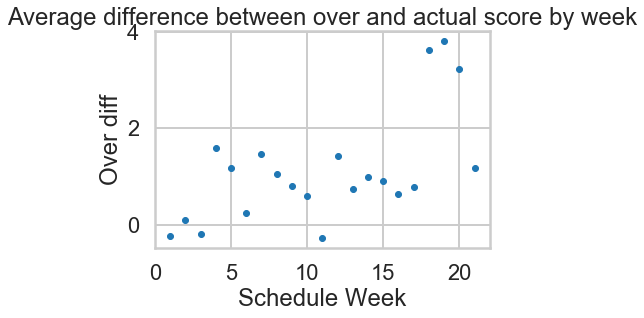

In [32]:
plt.plot( grp['over_diff'].mean(), linestyle='none', marker='.')
plt.title('Average difference between over and actual score by week')
plt.xlabel('Schedule Week')
plt.ylabel('Over diff')

As we can see in the above graphs, the spread result difference has less variance then the Over_diff from week to week. Maybe line setters are better at point spreads than O/U. Probabloy not. What seems more likely is that the presence of weather have different effects on different aspects of the game. From the information that has been gathered here, I think the most interesting avenue for future research is how weather affects favorites versus how it affects underdogs. Same for Overs and Unders. Another potential avenue of study is which aspect of bad weather had the greatest effect on our dependent varibles. 

In [24]:
ppdf.to_pickle('ready_for_stats.pkl')